google drive の mount

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os

In [0]:
base_dir = "./drive/My Drive/chap06/".replace('/', os.sep)

# 第９章

## データの読み込み

In [0]:
import pandas as pd

In [0]:
DATA_DIR = base_dir+"data/"
TRAIN_DIR = DATA_DIR+"train.txt"
TEST_DIR = DATA_DIR + "test.txt"

In [0]:
train_data = pd.read_csv(TRAIN_DIR,sep="\t")
test_data = pd.read_csv(TEST_DIR,sep="\t")

In [10]:
train_data.shape

(12006, 9)

In [11]:
test_data.shape

(1334, 9)

## 80. ID番号への変換

### IDとwordを紐づけるクラスを定義

In [0]:
class Words:
    '''
    文書から、wordとidの対応を作る
    2以上出てくる後には、{id}>0
    1かいしか出てこない語には、0を割り当てる
    '''
    def __init__(self):
        """
        word2id ;dict(key=word,val=id)
        id2word: dict(key=id,val=word)
        appear_word:　一回でも出現した言葉
        added_word: 辞書にすでに追加されている言葉
        """
        self.word2id=dict()
        self.id2word=dict()
        self.appear_word=set()
        self.added_word=set()
        
    def add_word(self,word):
        """
        add word to dict
        """
        if not word in self.added_word and word in self.appear_word:#2回目の出現の時
            self.added_word.add(word)
            word_id = len(self.added_word)
            self.word2id[word]=word_id
            self.id2word[word_id] = word
        else:
            self.appear_word.add(word)
            
    def add_sentence(self,sentence):
        """
        add sentence to dict
        """
        #前処理とかするといいかも /ToDo
        for word in sentence.split():
            self.add_word(word)
            
    def add_from_data(self,data_frame):
        """
        dataFrameから追加する
        """
        for d in data_frame:
            self.add_sentence(d)
            
            
    def word_to_id(self,sentence):
        """
        与えられた文字列を、単語idの列にする
        """
        ret=[]
        #前処理
        for word in sentence.split():
            if word in self.added_word:
                ret.append(self.word2id[word])
            else:
                ret.append(0)
        return ret
    
    def id_to_word(self,ids):
        """
        idの列(list)を文字列に直す
        """
        ret=[]
        for ind in ids:
            try:
                ret.append(id2word[id])
            except KeyError:
                pass
        return " ".join(ret)            

### モデルに単語を入れていく

In [0]:
Word2Id=Words()

train dataを辞書に追加していく

In [0]:
Word2Id.add_from_data(train_data["TITLE"])

In [15]:
len(Word2Id.added_word)

11210

### 単語列をid列にする

In [0]:
train_data["Id_seq"] = train_data["TITLE"].apply(lambda s:Word2Id.word_to_id(s))
test_data["Id_seq"] = test_data["TITLE"].apply(lambda s:Word2Id.word_to_id(s))

### dataとlabelに分ける

In [0]:
trainX = train_data["Id_seq"]
trainY = train_data["CATEGORY"]

In [0]:
testX=test_data["Id_seq"]
testY = test_data["CATEGORY"]

### titleの長さをplot

In [0]:
import matplotlib.pyplot as plt

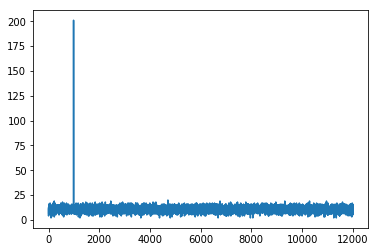

In [20]:
plt.plot([len(x) for x in trainX])

見た感じ、20くらいに集中してるから、長さ20にパディングする

## 81 RNNによる予測

In [21]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


### 共通の設定

In [0]:
hidden_size=500
length_of_sequences=20 #だいたいみんな20くらいだったから
max_features=len(Word2Id.added_word)+1 #出てくるwordの種類数
emb_dim=300
ans_dim=4 # pred output dim
N_epoch=10
N_batch=32

## データを整える

In [0]:
def fix_length(data,max_len):
    """
    idのlistの長さを揃える
    """
    return sequence.pad_sequences(data,maxlen=max_len)

In [0]:
def label_one_hot(label_data):
    return  pd.get_dummies(label_data)

### train

In [0]:
train_x=fix_length(trainX,length_of_sequences)
test_x = fix_length(testX,length_of_sequences)

### test

In [0]:
train_y = label_one_hot(trainY)
test_y = label_one_hot(testY)

## train結果のプロット

In [0]:
# loss
def plot_history_loss(fit,ax):
    # Plot the loss in the history
    ax.plot(fit.history['loss'],label="loss for training")
    ax.plot(fit.history['val_loss'],label="loss for validation")
    ax.set_title('model loss')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')

# acc
def plot_history_acc(fit,ax):
    # Plot the loss in the history
    ax.plot(fit.history['acc'],label="acc for training")
    ax.plot(fit.history['val_acc'],label="acc for validation")
    ax.set_title('model accuracy')
    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy')
    ax.legend(loc='upper left')

In [0]:
def plot_history(history):
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
    plot_history_loss(history,axL)
    plot_history_acc(history,axR)
    plot.show()
    print("acc->",history.history["acc"])
    print("loss->",history.history["loss"])

### model の作成

In [0]:
from keras.models import Model
from keras.layers import Dense,Activation,Input,Add
from keras.layers import LSTM,Embedding,Bidirectional
from keras.preprocessing import sequence

In [0]:
def build_simple_model(use_emb=False,emb_mat=None,verbose=True):
    inp = Input(shape=(length_of_sequences,))
    if use_emb:
        emb = Embedding(output_dim=emb_dim, input_dim=max_features, input_length=length_of_sequences,weights=[emb_mat])(inp)
    else:
        emb = Embedding(output_dim=emb_dim, input_dim=max_features, input_length=length_of_sequences)(inp)
    lstm  = LSTM(hidden_size,return_sequences=False)(emb)
    out = Dense(ans_dim,activation="softmax")(lstm)   
    model = Model(inputs=inp,outputs=out)
    model.compile(loss="categorical_crossentropy",optimizer="SGD",metrics=["accuracy"])
    if verbose:
        model.summary()
    return model

### 予測

W0710 01:13:43.998968 139966391543680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0710 01:13:44.055658 139966391543680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0710 01:13:44.065593 139966391543680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0710 01:13:44.637121 139966391543680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0710 01:13:44.664337 139966391543680 deprecation_wrappe

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 20, 300)           3363300   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1204      
Total params: 4,085,704
Trainable params: 4,085,704
Non-trainable params: 0
_________________________________________________________________


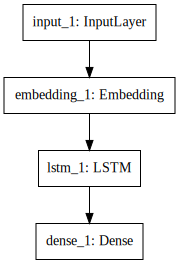

In [26]:
model = build_simple_model()
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [31]:
model.predict(train_x[:1])

W0710 01:13:45.129478 139966391543680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



array([[0.25039852, 0.24937168, 0.25097853, 0.24925128]], dtype=float32)

# 82 確率勾配降下法による学習

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 20)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 20, 300)           3363300   
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1204      
Total params: 4,085,704
Trainable params: 4,085,704
Non-trainable params: 0
_________________________________________________________________


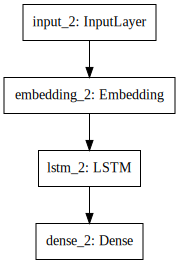

In [35]:
model = build_simple_model()
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [37]:
hist=model.fit(train_x,train_y,validation_data=(test_x,test_y),epochs=N_epoch,batch_size=N_batch,verbose=0)

W0710 01:13:46.387203 139966391543680 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


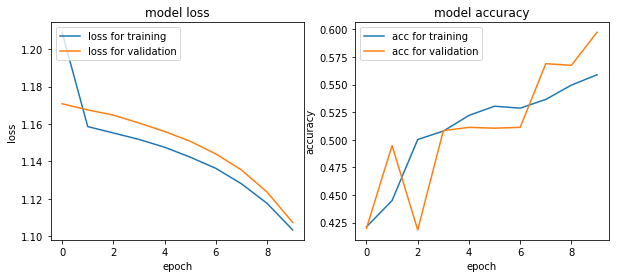

acc-> 0.558887223055139
loss-> 1.1033034010289333


In [38]:
plot_history(hist)

## 83 ミニバッチ

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 20)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 20, 300)           3363300   
_________________________________________________________________
lstm_3 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1204      
Total params: 4,085,704
Trainable params: 4,085,704
Non-trainable params: 0
_________________________________________________________________


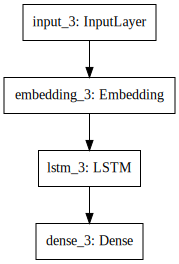

In [39]:
model = build_simple_model()
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## batch sizeを変えて色々やってみる and ちょうどいいバッチサイズを探す

batch-> 32


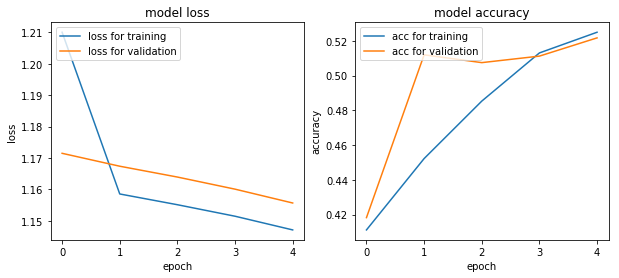

acc-> 0.5249875062468765
loss-> 1.1471090149565695
batch-> 64


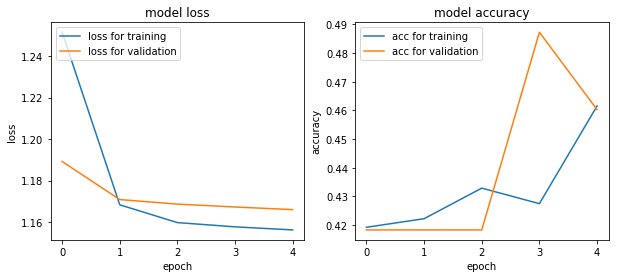

acc-> 0.46151924037981007
loss-> 1.1562205415834055
batch-> 128


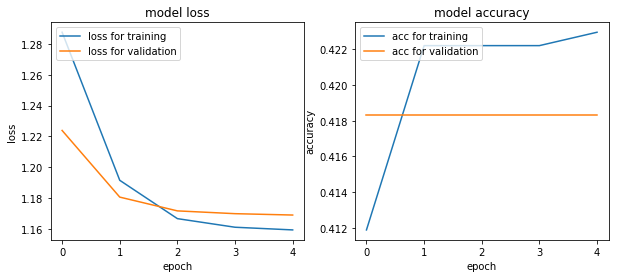

acc-> 0.42295518913170543
loss-> 1.1594863948316827
batch-> 256


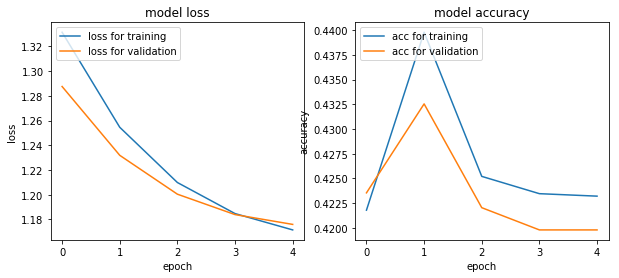

acc-> 0.4232050639707685
loss-> 1.1715091110248874
batch-> 512


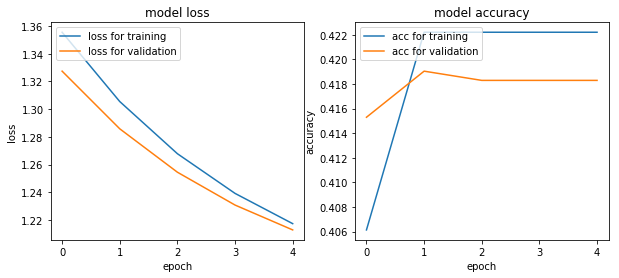

acc-> 0.4222055638052912
loss-> 1.2174684778364742


In [40]:
for B in [2**v for v in range(5,10)]:
    model = build_simple_model(verbose=False)
    hist=model.fit(train_x,label_one_hot(trainY),validation_data=(test_x,label_one_hot(testY)),epochs=5,batch_size=B,verbose=0)
    print("--------------------------")
    print("batch->",B)
    plot_history(hist)
    print("--------------------------")

## 単語ベクトルの導入

In [0]:
W2V_FILE = "./drive/My Drive/chap07/data/GoogleNews-vectors-negative300.bin.gz"

In [0]:
from gensim.models import KeyedVectors

In [43]:
word2vec= KeyedVectors.load_word2vec_format(W2V_FILE,binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### train_dataのembeddingを作る

In [0]:
EMBEDDING_DIM=emb_dim
vocabulary_size=max_features
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

for word, i in Word2Id.word2id.items():
    if i >max_features:
        continue
    try:
        embedding_vector = word2vec[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i] = np.random.normal(0, np.sqrt(0.25), EMBEDDING_DIM)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 20)                0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 20, 300)           3363300   
_________________________________________________________________
lstm_9 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 1204      
Total params: 4,085,704
Trainable params: 4,085,704
Non-trainable params: 0
_________________________________________________________________


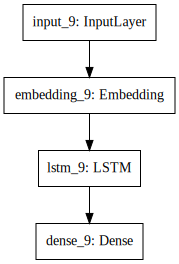

In [45]:
model = build_simple_model(use_emb=True,emb_mat=embedding_matrix)
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [0]:
hist=model.fit(train_x,label_one_hot(trainY),validation_data=(test_x,label_one_hot(testY)),epochs=N_epoch,batch_size=N_batch,verbose=0)

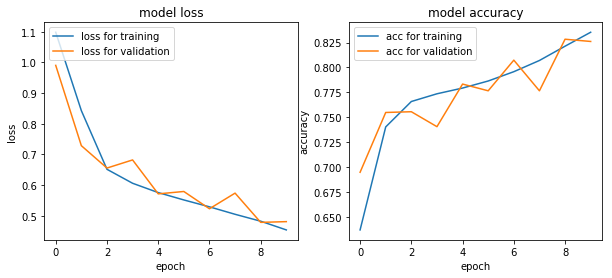

acc-> 0.8353323338330835
loss-> 0.45422294390870793


In [47]:
plot_history(hist)

## 85  BiDirectional RNN 多層化

### model1 
* inp->emb->bi_lstm->lstm->dense

In [0]:
def build_biDirectional_model(use_emb=False,emb_mat=None,verbose=True):
    inp = Input(shape=(length_of_sequences,))
    if use_emb:
        emb = Embedding(output_dim=hidden_size, input_dim=max_features, input_length=length_of_sequences,weights=[emb_mat])(inp)
    else:
        emb = Embedding(output_dim=hidden_size, input_dim=max_features, input_length=length_of_sequences)(inp)
    bi_lstm  = Bidirectional(LSTM(hidden_size,return_sequences=True))(emb)
    lstm = LSTM(hidden_size,return_sequences=False)(bi_lstm)
    out = Dense(4,activation="softmax")(lstm)   
    model = Model(inputs=inp,outputs=out)
    model.compile(loss="categorical_crossentropy",optimizer="SGD",metrics=["accuracy"])
    if verbose:
        model.summary()
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 20)                0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 20, 300)           3363300   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20, 600)           1442400   
_________________________________________________________________
lstm_11 (LSTM)               (None, 300)               1081200   
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 1204      
Total params: 5,888,104
Trainable params: 5,888,104
Non-trainable params: 0
_________________________________________________________________


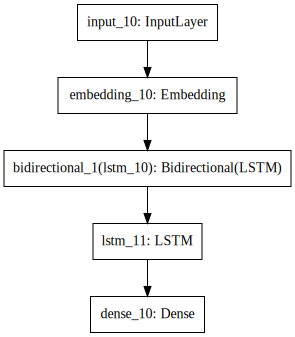

In [49]:
model = build_biDirectional_model(use_emb=True,emb_mat=embedding_matrix)
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [0]:
hist=model.fit(train_x,label_one_hot(trainY),validation_data=(test_x,label_one_hot(testY)),epochs=N_epoch,batch_size=N_batch,verbose=0)

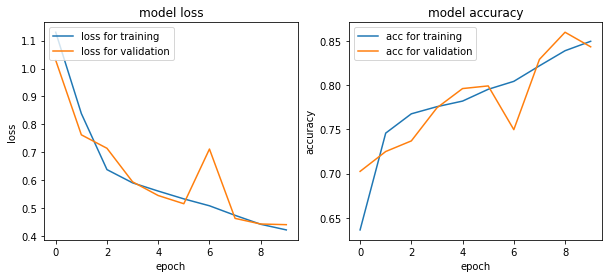

acc-> 0.8495752123938031
loss-> 0.42171088509682353


In [51]:
plot_history(hist)

### model2
* inp->emb->bi_lstm->(lstm)*3->dense

In [0]:
def build_biDirectional_model2(use_emb=False,emb_mat=None,verbose=True):
    inp = Input(shape=(length_of_sequences,))
    if use_emb:
        emb = Embedding(output_dim=hidden_size, input_dim=max_features, input_length=length_of_sequences,weights=[emb_mat])(inp)
    else:
        emb = Embedding(output_dim=hidden_size, input_dim=max_features, input_length=length_of_sequences)(inp)
    bi_lstm  = Bidirectional(LSTM(hidden_size,return_sequences=True),merge_mode="ave")(emb)
    lstm1 = LSTM(hidden_size,return_sequences=True)(bi_lstm)
    lstm2 = LSTM(hidden_size,return_sequences=True)(lstm1)
    lstm3= LSTM(hidden_size)(lstm2)
    out = Dense(4,activation="softmax")(lstm3)   
    model = Model(inputs=inp,outputs=out)
    model.compile(loss="categorical_crossentropy",optimizer="SGD",metrics=["accuracy"])
    if verbose:
        model.summary()
    return model
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 20)                0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 20, 300)           3363300   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 20, 300)           1442400   
_________________________________________________________________
lstm_13 (LSTM)               (None, 20, 300)           721200    
_________________________________________________________________
lstm_14 (LSTM)               (None, 20, 300)           721200    
_________________________________________________________________
lstm_15 (LSTM)               (None, 300)               721200    
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 1204      
Total para

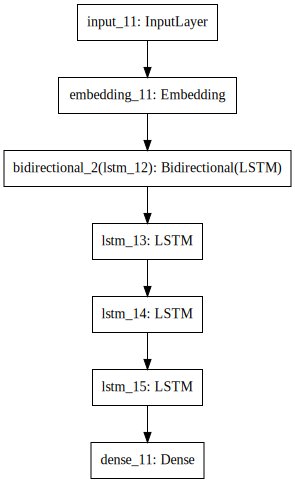

In [53]:
model =build_biDirectional_model2(use_emb=True,emb_mat=embedding_matrix)
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [0]:
hist=model.fit(train_x,label_one_hot(trainY),validation_data=(test_x,label_one_hot(testY)),epochs=N_epoch,batch_size=N_batch,verbose=0 )

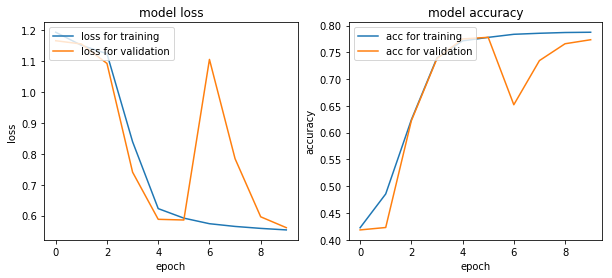

acc-> 0.78760619689162
loss-> 0.5537299975571623


In [55]:
plot_history(hist)

### model3
model2+residual conection  
(residualやってみたかっただけです)  
epoch少ないから過学習起きなさそうで、あんま意味なかったかな

In [0]:
def build_biDirectional_model3(use_emb=False,emb_mat=None,verbose=True):
    inp = Input(shape=(length_of_sequences,))
    if use_emb:
        emb = Embedding(output_dim=hidden_size, input_dim=max_features, input_length=length_of_sequences,weights=[emb_mat])(inp)
    else:
        emb = Embedding(output_dim=hidden_size, input_dim=max_features, input_length=length_of_sequences)(inp)
    bi_lstm  = Bidirectional(LSTM(hidden_size,return_sequences=True),merge_mode="ave")(emb)
    lstm1 = LSTM(hidden_size,return_sequences=True)( bi_lstm)
    lstm2 = LSTM(hidden_size,return_sequences=True)(lstm1)
    residual = Add()([lstm1,lstm2])
    lstm3= LSTM(hidden_size)(residual)
    out = Dense(4,activation="softmax")(lstm3)   
    model = Model(inputs=inp,outputs=out)
    model.compile(loss="categorical_crossentropy",optimizer="SGD",metrics=["accuracy"])
    if verbose:
        model.summary()
    return model

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 20, 300)      3363300     input_12[0][0]                   
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 20, 300)      1442400     embedding_12[0][0]               
__________________________________________________________________________________________________
lstm_17 (LSTM)                  (None, 20, 300)      721200      bidirectional_3[0][0]            
__________________________________________________________________________________________________
lstm_18 (L

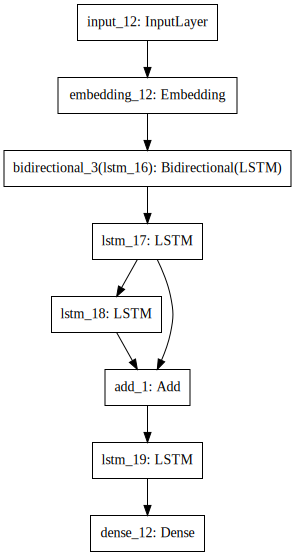

In [57]:
model = build_biDirectional_model3(use_emb=True,emb_mat=embedding_matrix)
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [0]:
hist=model.fit(train_x,label_one_hot(trainY),validation_data=(test_x,label_one_hot(testY)),epochs=N_epoch,batch_size=N_batch,verbose=0)

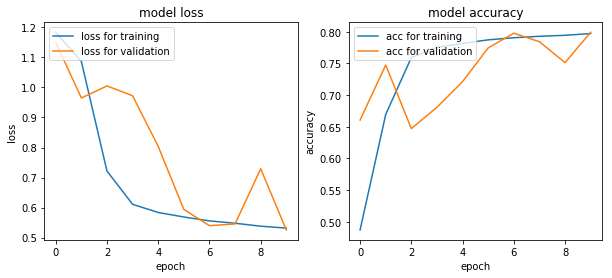

acc-> 0.7970181575978019
loss-> 0.531725622714807


In [59]:
plot_history(hist)